In [1]:
import numpy as np 
import pandas as pd 

# keras 
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor

# model evaluation

seed = 88

import os 

import matplotlib.pyplot as plt
import seaborn as sns

from vecstack import stacking

from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer, StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

Using TensorFlow backend.
/media/tin/DATA/newbigtf/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Loading transformed data

INPUT = '/media/tin/DATA/Kaggle/Mercedes/Input/'
OUTPUT = '/media/tin/DATA/Kaggle/Mercedes/Output/'

train = pd.read_csv(os.path.join(INPUT, 'train_engineer.csv'))
test = pd.read_csv(os.path.join(INPUT, 'test_engineer.csv'))

y_train = train["y"]
x_train = train.drop('y', axis=1)

test_id = pd.read_csv(os.path.join(INPUT, 'test.csv'))["ID"]


print('Shape train: {}\nShape test: {}\nShape y_train: {}\nShape x_train: {}'
      .format(train.shape,
              test.shape, 
              y_train.shape, 
              x_train.shape))

Shape train: (4209, 653)
Shape test: (4209, 652)
Shape y_train: (4209,)
Shape x_train: (4209, 652)


In [3]:
# function for hyperopt

def hyper(f, trials):
    best = fmin(f, space, algo=tpe.suggest, max_evals = 100, trials = trials)
    print ('best:')
    print (best)
    return best

k_fold = KFold(n_splits = 5, shuffle = True, random_state = seed)

def cvs_mean(clf):
    score = cross_val_score(clf, x_train, y_train, n_jobs = -1, 
                            cv = k_fold, scoring = 'r2').mean()
    return score

def cvs_mean_keras(clf):
    score = cross_val_score(clf, np.array(x_train), np.array(y_train), 
                            cv = k_fold, scoring = 'r2').mean()
    return score

def grap(trials_received):
    trials = trials_received
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    np.array(ys)
    return xs, ys

cmap = plt.cm.jet

best:
{'n_estimators': 24, 'max_features': 0, 'bootstrap': 1, 'max_depth': 3}


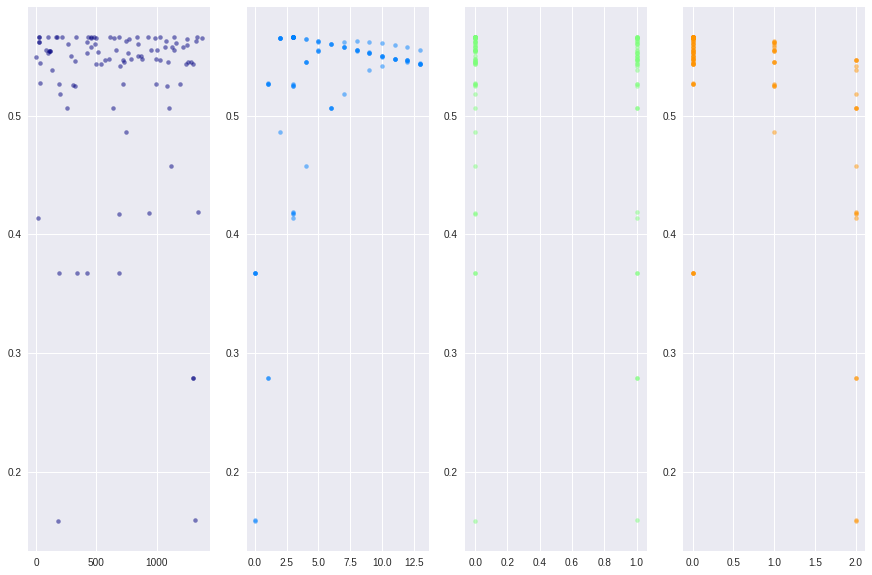

In [5]:
# 1. ExtraTreesRegressor
space = {'max_depth': hp.choice('max_depth', range(1, 15)),
    'n_estimators': hp.choice('n_estimators', range(100, 1500)),
    'bootstrap': hp.choice ('bootstrap', ["False", "True"]),
    'max_features': hp.choice ('max_features', ["auto", "sqrt", "log2"])   
        }

def f(params):
    r2 = cvs_mean(ExtraTreesRegressor(**params))  ##what is **
    return {'loss': -r2, 'status': STATUS_OK}

trials3 = Trials()
best = hyper(f, trials3)

parameters = ['n_estimators', 'max_depth', 'bootstrap', 'max_features']
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,10))

for i, val in enumerate(parameters):
    xs, ys = grap(trials3) 
    #xs, ys = zip(\*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, 
                    c=cmap(float(i)/len(parameters)))
    #axes[i/3,i%3].set_title(val)
plt.show()

best:
{'min_samples_leaf': 0, 'min_weight_fraction_leaf': 0.015417563447637587, 'min_samples_split': 0.2678325929735103, 'max_depth': 2}


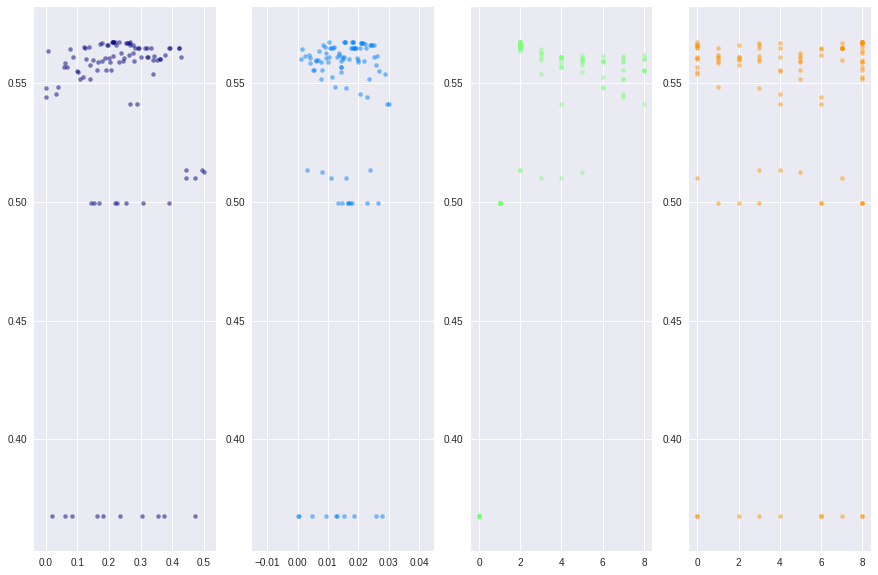

In [7]:
# 2. DecisionTreeRegressor
space = {'min_samples_split' : hp.uniform('min_samples_split', 0, 0.5),
         'min_weight_fraction_leaf': hp.uniform ('min_weight_fraction_leaf', 0, 0.03),
         'max_depth': hp.choice('max_depth', range(1, 10)),
         'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10))
        }

def f(params):
    r2 = cvs_mean(DecisionTreeRegressor(**params))  
    return {'loss': -r2, 'status': STATUS_OK}

trials3 = Trials()
best = hyper(f, trials3)

parameters = ['min_samples_split', 'min_weight_fraction_leaf', 'max_depth', 'min_samples_leaf']
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,10))

for i, val in enumerate(parameters):
    xs, ys = grap(trials3) 
    #xs, ys = zip(\*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, 
                    c=cmap(float(i)/len(parameters)))
    #axes[i/3,i%3].set_title(val)
plt.show()

In [ ]:
######XGB

space = {'learning_rate' : hp.quniform('learning_rate', 0.025, 0.2, 0.025),
         'subsample': hp.uniform ('subsample', 0.7, 1),
         'max_depth': hp.choice('max_depth', range(1, 8)),
         'n_estimators': hp.choice('n_estimators', range(100, 1200))
        }

def f(params):
    r2 = cvs_mean(XGBRegressor(**params))  
    return {'loss': -r2, 'status': STATUS_OK}

trials4 = Trials()
best = hyper(f, trials4)

parameters = ['learning_rate', 'subsample', 'max_depth', 'n_estimators']
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,10))

for i, val in enumerate(parameters):
    print (i, val)
    xs, ys = grap(xs, ys, trials4) 
    #xs, ys = zip(\*sorted(zip(xs, ys)))
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, 
                    c=cmap(float(i)/len(parameters)))
    #axes[i/3,i%3].set_title(val)
plt.show()